## Processing data without staurosporine

### Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd

def add_gene_name(data):   
    desp = data['Description'].values
    gene = []
    for s in desp:
        
        g = s[s.find('GN=') + 3:].split(' ')[0]
        gene.append(g)
    data['Gene Symbol'] = gene
    return data


def preprocess_single(data):
    columns = ['Accession',
               '# PSMs',
               'Gene Symbol']
    val_cols = [s for s in data.columns if 'Abundances (Normalized):' in s]
    val_cols = val_cols[:len(val_cols)-2]
    columns += val_cols
    new_data = data[columns]
    new_columns = columns[:3] + ['Abundances_Pool_{}'.format(i) for i in range(9)]
    new_data.columns = new_columns
    return new_data


# load raw data
ptable = pd.read_csv('data/NoStauro/protein_table.csv')

# preprocessing
ptable = add_gene_name(ptable)
new_ptable = preprocess_single(ptable)

# save data
new_ptable.to_csv('data/NoStauro/preprocessed_table.csv', index = False)

### Statistical analysis with LASSO

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from core.core import *

pool_matrix = pd.read_excel('data/NoStauro/sensing_matrix.xlsx')
pool_matrix = pool_matrix.fillna(0)

scores, fold_changes = post_analysis(new_ptable, pool_matrix, drug_num = 3)

scores.to_csv('data/NoStauro/scores.csv')
fold_changes.to_csv('data/NoStauro/fold_changes.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 3580/3580 [00:19<00:00, 187.40it/s]


### Result of verification set

           drug  target  rank           mark  size
0   Palbociclib    CDK4     2  1 > rank >= 5   350
1   Palbociclib    CDK6     5  1 > rank >= 5   350
2   Palbociclib   HDAC1  3541      rank > 25    50
3   Palbociclib   HDAC2  3541      rank > 25    50
4   Palbociclib    TYMS  3541      rank > 25    50
..          ...     ...   ...            ...   ...
94     Olaparib    BRAF  3541      rank > 25    50
95     Olaparib  MAPK14  3541      rank > 25    50
96     Olaparib  MAP2K1  3541      rank > 25    50
97     Olaparib  MAP2K2  3541      rank > 25    50
98     Olaparib   PARP1  3541      rank > 25    50

[99 rows x 5 columns]


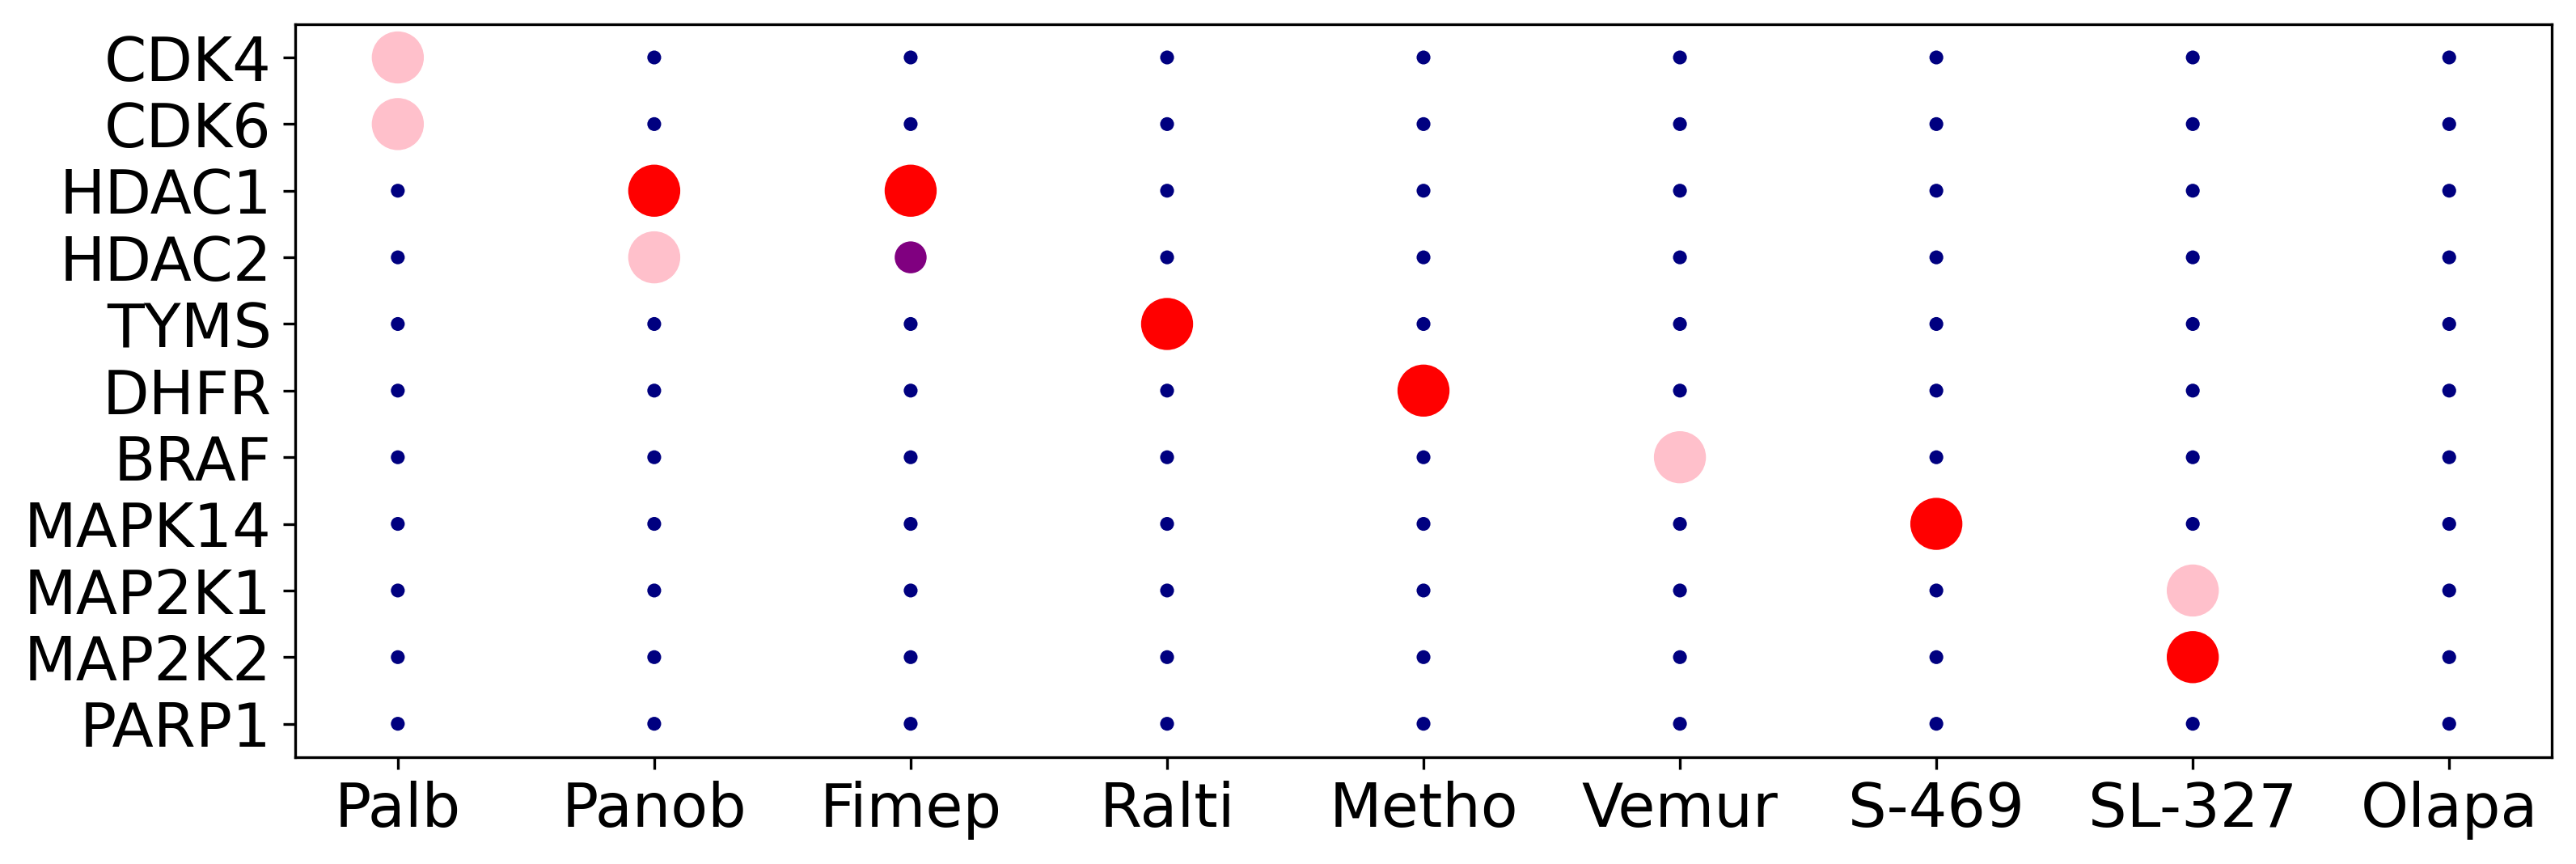

In [3]:
drug_targets = {'Palbociclib': ['CDK4', 'CDK6'], 
                'Panobinostat': ['HDAC1', 'HDAC2'],
                'Fimepinostat': ['HDAC1', 'HDAC2'],
                'Raltitrexed': ['TYMS'], 
                'Methotrexate': ['DHFR'], 
                'Vemurafenib': ['BRAF'],
                'SCIO-469': ['MAPK14'],
                'SL-327': ['MAP2K1', 'MAP2K2'],
                'Olaparib': ['PARP1']}

drugs = ['Palbociclib', 'Panobinostat', 'Fimepinostat', 'Raltitrexed', 
         'Methotrexate', 'Vemurafenib', 'SCIO-469', 'SL-327', 'Olaparib']

targets = ['CDK4', 'CDK6', 'HDAC1', 'HDAC2', 'TYMS', 'DHFR', 
          'BRAF', 'MAPK14', 'MAP2K1', 'MAP2K2', 'PARP1']

def plat_target_ranking(scores, drug_targets):
    plt_data = []
    for drug in drugs:
        for t in targets:
            w = np.where(scores['Gene Symbol'] == t)[0][0]
            if drug not in scores.columns:
                rank = np.nan
                mark = str('not included')
                plt_data.append([drug, t, rank, mark])
                continue
            score = scores[drug][w]
            rank = len(np.where(scores[drug] >= score)[0])
            if rank > 25:
                mark = 'rank > 25'
                ss = 50
            elif rank > 10:
                mark = '10 > rank >= 25'
                ss = 150
            elif rank > 5:
                mark = '5 > rank >= 10'
                ss = 250
            elif rank > 1:
                mark = '1 > rank >= 5'
                ss = 350
            else:
                mark = 'rank = 1'
                ss = 350
            plt_data.append([drug, t, rank, mark, ss])
    plt_data = pd.DataFrame(plt_data)
    plt_data.columns = ['drug', 'target', 'rank', 'mark', 'size']
    print(plt_data)
    
    flatui = ['red', 'pink', 'orange', 'purple', 'navy']
    hue_order = ['rank = 1', '1 > rank >= 5', '5 > rank >= 10', '10 > rank >= 25', 'rank > 25']
    my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    plt.figure(dpi = 300, figsize = (12, 4))
    sns.scatterplot(x='drug', y='target', hue='mark', data=plt_data, size='size', palette = my_cmap.colors,
                    hue_order = hue_order, legend = False, sizes=(20, 250))
    plt.xticks(fontsize = 18, ticks = np.arange(len(drugs)), labels = ['Palb', 'Panob', 'Fimep', 'Ralti', 'Metho', 'Vemur', 'S-469', 'SL-327', 'Olapa'])
    plt.yticks(fontsize = 18)
    plt.xlabel('')
    plt.ylabel('')
    # plt.legend(loc='upper right', bbox_to_anchor=(1.39, 1), fontsize = 20, markerscale = 2)

plat_target_ranking(scores, drug_targets)

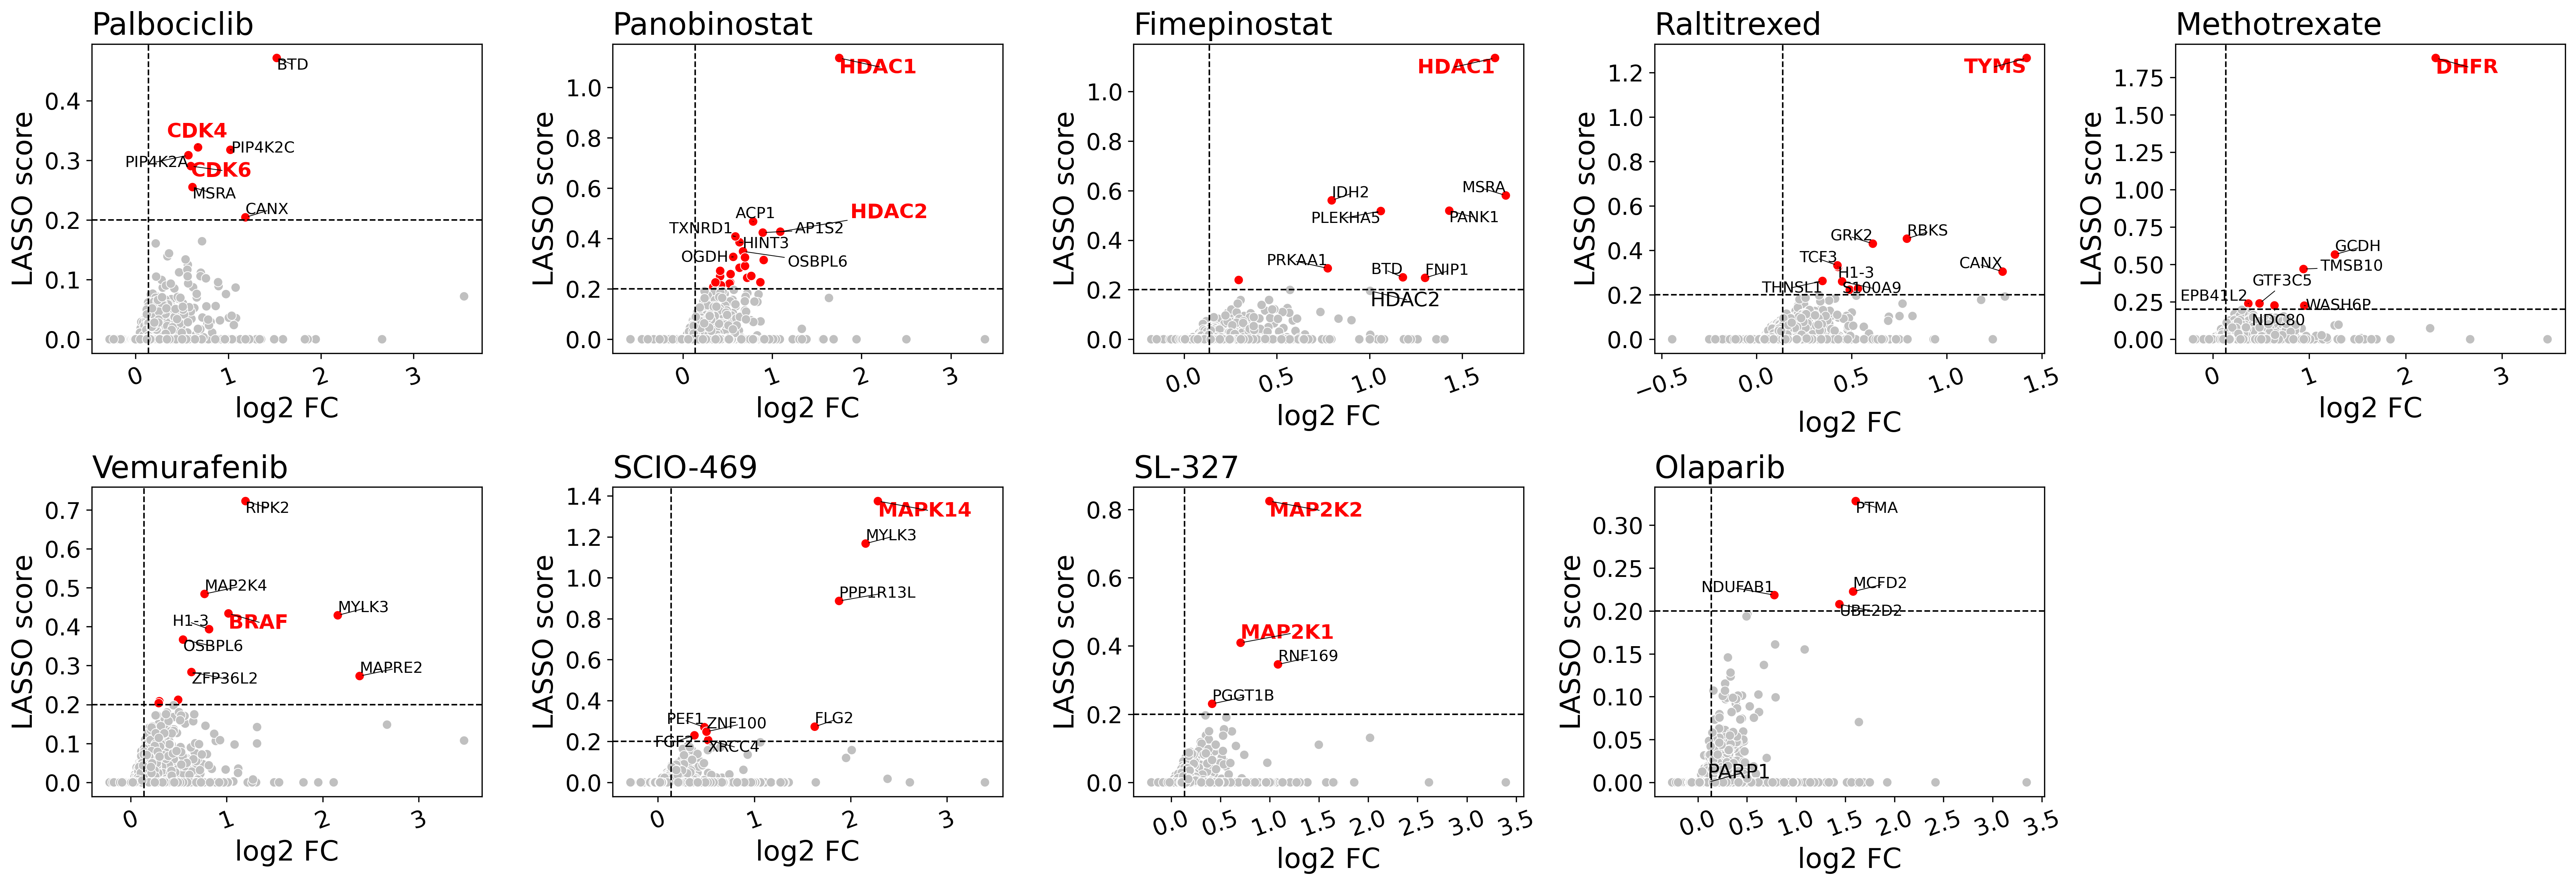

In [4]:
# plot the result
i = 1
plt.figure(dpi = 300, figsize = (23.3, 8))
for d, genes in drug_targets.items():
    plt.subplot(2,5,i)
    plot_results(d, scores, fold_changes, genes, fc_thres = 1.1, score_thres=0.2, top_markers = 8)
    i += 1
plt.tight_layout()

### Result of exploratory set

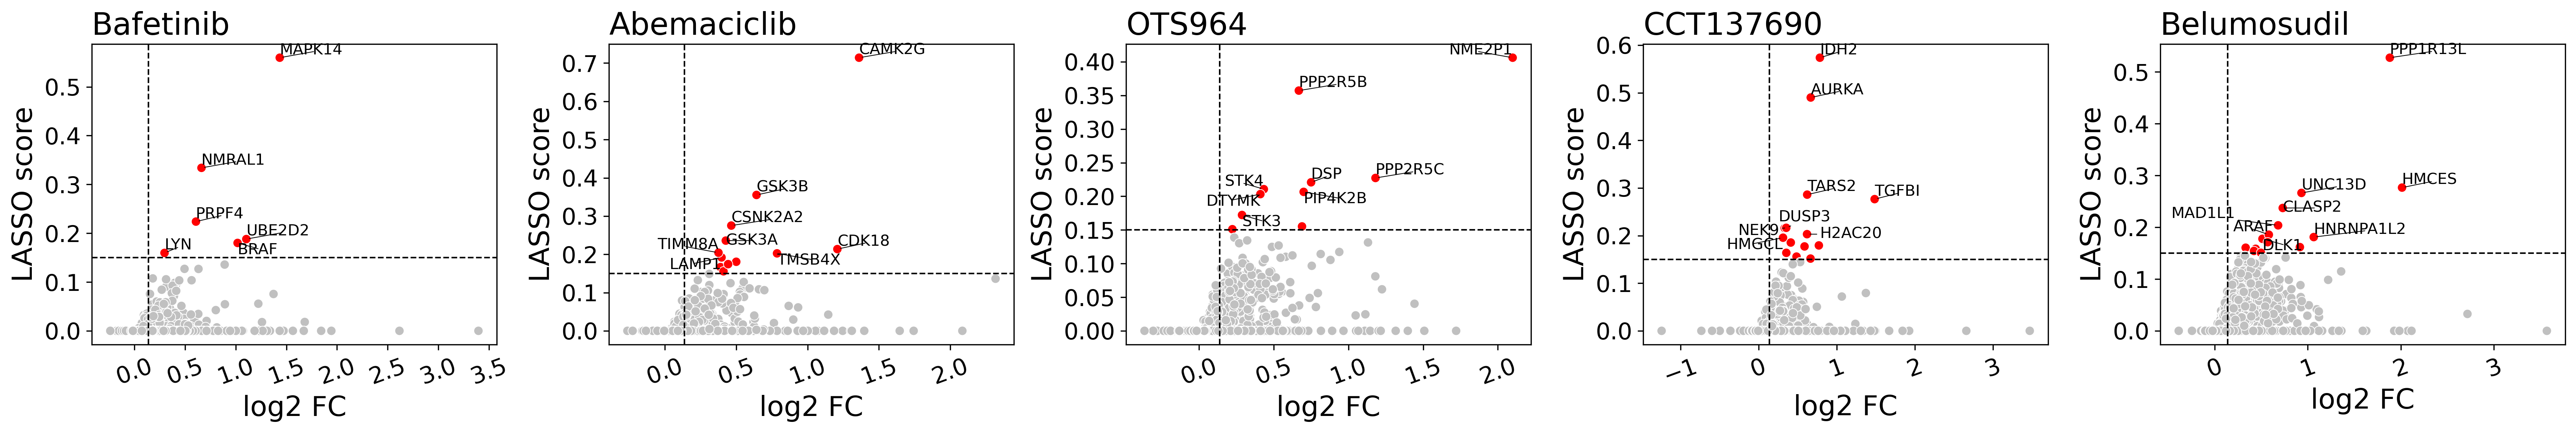

In [5]:
# define the drugs
drugs = ['Bafetinib', 'Abemaciclib', 'OTS964', 'CCT137690', 'Belumosudil']

plt.figure(dpi = 300, figsize = (23.3, 4))
for i, d in enumerate(drugs):
    plt.subplot(1,5,1+i)
    plot_results(d, scores, fold_changes, fc_thres = 1.1, score_thres=0.15, top_markers = 8)
plt.tight_layout()